In [51]:
import argparse
import cv2
import numpy
import scipy
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage


from demo import Demonstration
from trainer import Trainer

%matplotlib inline

In [2]:
def read_image(path: str, img_type: str):
    """
    Reads image into numpy array
    @param path: Path to image
    @param img_type: One of 'color', 'depth'
    @return: Array containing image contents
    """
    # This is repeated several times in the code and should ideally be refactored into a function

    if img_type == "color":
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    elif img_type == "depth":
        return numpy.stack([cv2.imread(path, -1)]*3, axis=-1).astype(numpy.float32)/100000
    return None

In [3]:
# Workspace limits
workspace_limits = numpy.asarray([[-0.724, -0.276], [-0.224, 0.224], [-0.0001, 0.5]])

# Test images
test_color_heightmap = read_image("logs/2021-02-28-17-19-14_Real-Stack-Imitation-Masked-Testing-Three-Step-History/data/color-heightmaps/000015.0.color.png", 'color')
test_depth_heightmap = read_image("logs/2021-02-28-17-19-14_Real-Stack-Imitation-Masked-Testing-Three-Step-History/data/depth-heightmaps/000015.0.depth.png", 'depth')

# Demo files
demo = Demonstration("logs/stack_demos", 1, None)
demo_color_heightmap, demo_depth_heightmap = demo.get_heightmaps("place", 11)

# stack_snapshot_file = 'logs/base_models/best_stack/snapshot.reinforcement_trial_success_rate_best_value.pth'
stack_snapshot_file = 'logs/base_models/best_unstacking/snapshot.reinforcement_trial_success_rate_best_value.pth'
stack_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                        is_testing=True, snapshot_file=stack_snapshot_file,
                        force_cpu=False, goal_condition_len=0, place=True,
                        pretrained=True, flops=False, network='densenet',
                        common_sense=True, place_common_sense=True,
                        show_heightmap=False, place_dilation=0.01,
                        common_sense_backprop=True, trial_reward='spot',
                        num_dilation=0)

CUDA detected. Running with GPU acceleration.


/home/absox/PycharmProjects/real_good_robot/venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Pre-trained model snapshot loaded from: logs/base_models/best_unstacking/snapshot.reinforcement_trial_success_rate_best_value.pth


In [4]:
# get demo action index vector
action_vector = demo.action_dict[2][2]

# convert rotation angle to index
best_rot_ind = numpy.around((numpy.rad2deg(action_vector[-2]) % 360) * 16 / 360).astype(int)
test_rot_ind = 1

# convert robot coordinates to pixel
workspace_pixel_offset = workspace_limits[:2, 0] * -1 * 1000
best_action_xy = ((workspace_pixel_offset + 1000 * action_vector[:2]) / 2).astype(int)

print(best_action_xy)
print(best_rot_ind)

[ 83 142]
10


In [5]:
_, _, demo_features = stack_trainer.forward(demo_color_heightmap, demo_depth_heightmap,
                                            is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
demo_features = demo_features.filled(0.0)

In [6]:
_, _, test_features = stack_trainer.forward(test_color_heightmap, test_depth_heightmap,
                                            is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
test_features = test_features.filled(0.0)


In [7]:
demo_features_rot = demo_features[best_rot_ind,:,:,:]
test_features_rot = test_features[test_rot_ind,:,:,:]

# Compute mask
demo_mask = (demo_features_rot == 0).all(axis=0)
test_mask = (test_features_rot == 0).all(axis=0)

(71, 136)


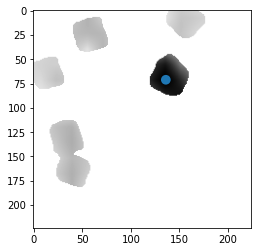

In [8]:
match_dist = numpy.zeros([224, 224])
for i in range(0, 224):
    for j in range(0, 224):
        match_dist[i,j] = numpy.sum(numpy.square(demo_features_rot[:, best_action_xy[1], best_action_xy[0]] - test_features_rot[:, i, j]))
match_dist[test_mask] = numpy.max(match_dist)*1.1
# match_dist = numpy.sqrt(match_dist)

matched_action = numpy.unravel_index(numpy.argmin(match_dist), match_dist.shape)

fig, ax = plt.subplots(1)
ax.imshow(match_dist, cmap="gray")
circle = Circle((matched_action[1], matched_action[0]))
ax.add_patch(circle)
print(matched_action)

In [9]:
rematch_squared_distance = numpy.zeros([224, 224])

for i in range(0, 224):
    for j in range(0, 224):
        x = numpy.expand_dims(test_features_rot[:,i,j], (1,2))
        displacement = demo_features_rot - x
        distances = numpy.sum(numpy.square(displacement), axis=0)
        distances = ndimage.gaussian_filter(distances, sigma=(3,3))
        distances[demo_mask] = numpy.max(distances) * 1.1
        match_index = numpy.unravel_index(numpy.argmin(distances), (224, 224))
        rematch_squared_distance[i,j] = numpy.sum(numpy.square(match_index - best_action_xy[[1, 0]]))

rematch_distance = numpy.sqrt(rematch_squared_distance)

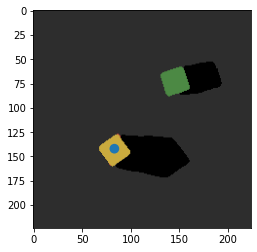

In [10]:
fig, ax = plt.subplots(1)

ax.imshow(demo_color_heightmap)
circle = Circle(best_action_xy)
ax.add_patch(circle)
# fig, ax = plt.imshow(demo_color_heightmap)


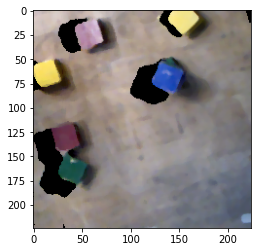

In [11]:
plt.imshow(test_color_heightmap)

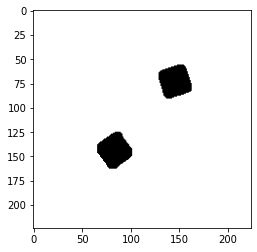

In [12]:
plt.imshow(demo_mask, cmap='gray')

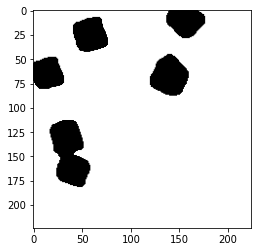

In [13]:
plt.imshow(test_mask, cmap='gray')

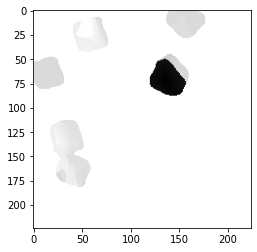

In [14]:
rematch_distance[test_mask] = numpy.max(rematch_distance)
plt.imshow(rematch_distance, cmap='gray')

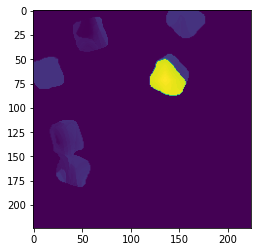

In [47]:
inverse_heights = numpy.max(rematch_distance) - rematch_distance
inverse_heights[test_mask] = 0
# inverse_heights[~test_mask] = 200

plt.imshow(inverse_heights)


True

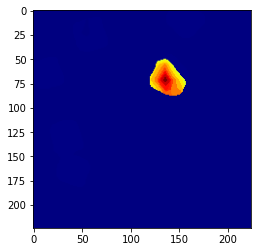

In [54]:
inverse_heights_scaled = (inverse_heights - numpy.mean(inverse_heights))/numpy.std(inverse_heights)
inverse_heights_softmax = scipy.special.softmax(inverse_heights_scaled)
# inverse_heights_softmax = numpy.log(numpy.exp(inverse_heights_scaled)/numpy.sum(numpy.exp(inverse_heights_scaled)))
inverse_heights_softmax = (inverse_heights_softmax - numpy.min(inverse_heights_softmax))/(numpy.max(inverse_heights_softmax-numpy.min(inverse_heights_softmax)))

inverse_heights_image = cv2.applyColorMap(((1-inverse_heights_softmax/numpy.max(inverse_heights_softmax))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
plt.imshow(inverse_heights_image)

inverse_heights_image_reverse = cv2.applyColorMap(((inverse_heights_softmax/numpy.max(inverse_heights_softmax))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
cv2.imwrite("figures/inverse_heights_softmax.png", inverse_heights_image_reverse)

In [ ]:
inverse_heights_image = cv2.applyColorMap(((1-inverse_heights/numpy.max(inverse_heights))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
plt.imshow(inverse_heights_image)

inverse_heights_image_reverse = cv2.applyColorMap(((inverse_heights/numpy.max(inverse_heights))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
cv2.imwrite("figures/inverse_heights.png", inverse_heights_image_reverse)

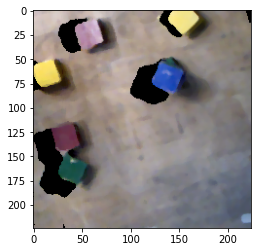

In [18]:
plt.imshow(test_color_heightmap)

In [19]:
# blended = blend(inverse_heights_image, test_color_heightmap)

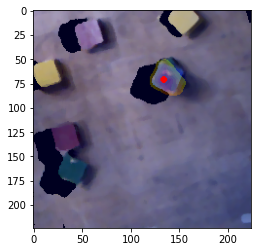

In [55]:
# Compute colors
# colors = [test_color_heightmap[i,j,:]/255 for j in range(0, 224) for i in range(0, 224)]
x = [i for j in range(0, 224) for i in range(0, 224)]
y = [j for j in range(0, 224) for i in range(0, 224)]
top = [inverse_heights[i,j] for j in range(0, 224) for i in range(0, 224)]
# top = [inverse_heights_softmax[i,j] for j in range(0, 224) for i in range(0, 224)]

best_test_action_index = numpy.argmax(top)
best_test_action = (y[best_test_action_index], x[best_test_action_index])
# inverse_heights_image = cv2.circle(inverse_heights_image, best_test_action, 2, (255, 0, 0), 2)
blended = cv2.addWeighted(inverse_heights_image, 0.25, test_color_heightmap, 0.75, 0)


blended = cv2.circle(blended, best_test_action, 2, (255, 0, 0), 2)
plt.imshow(blended)

colors = [blended[i,j,:]/255 for j in range(0, 224) for i in range(0, 224)]
# _x = numpy.arange(224)
# _y = numpy.arange(224)
# _xx, _yy = numpy.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# top = inverse_heights.flatten('C')
bottom = numpy.zeros(len(top))

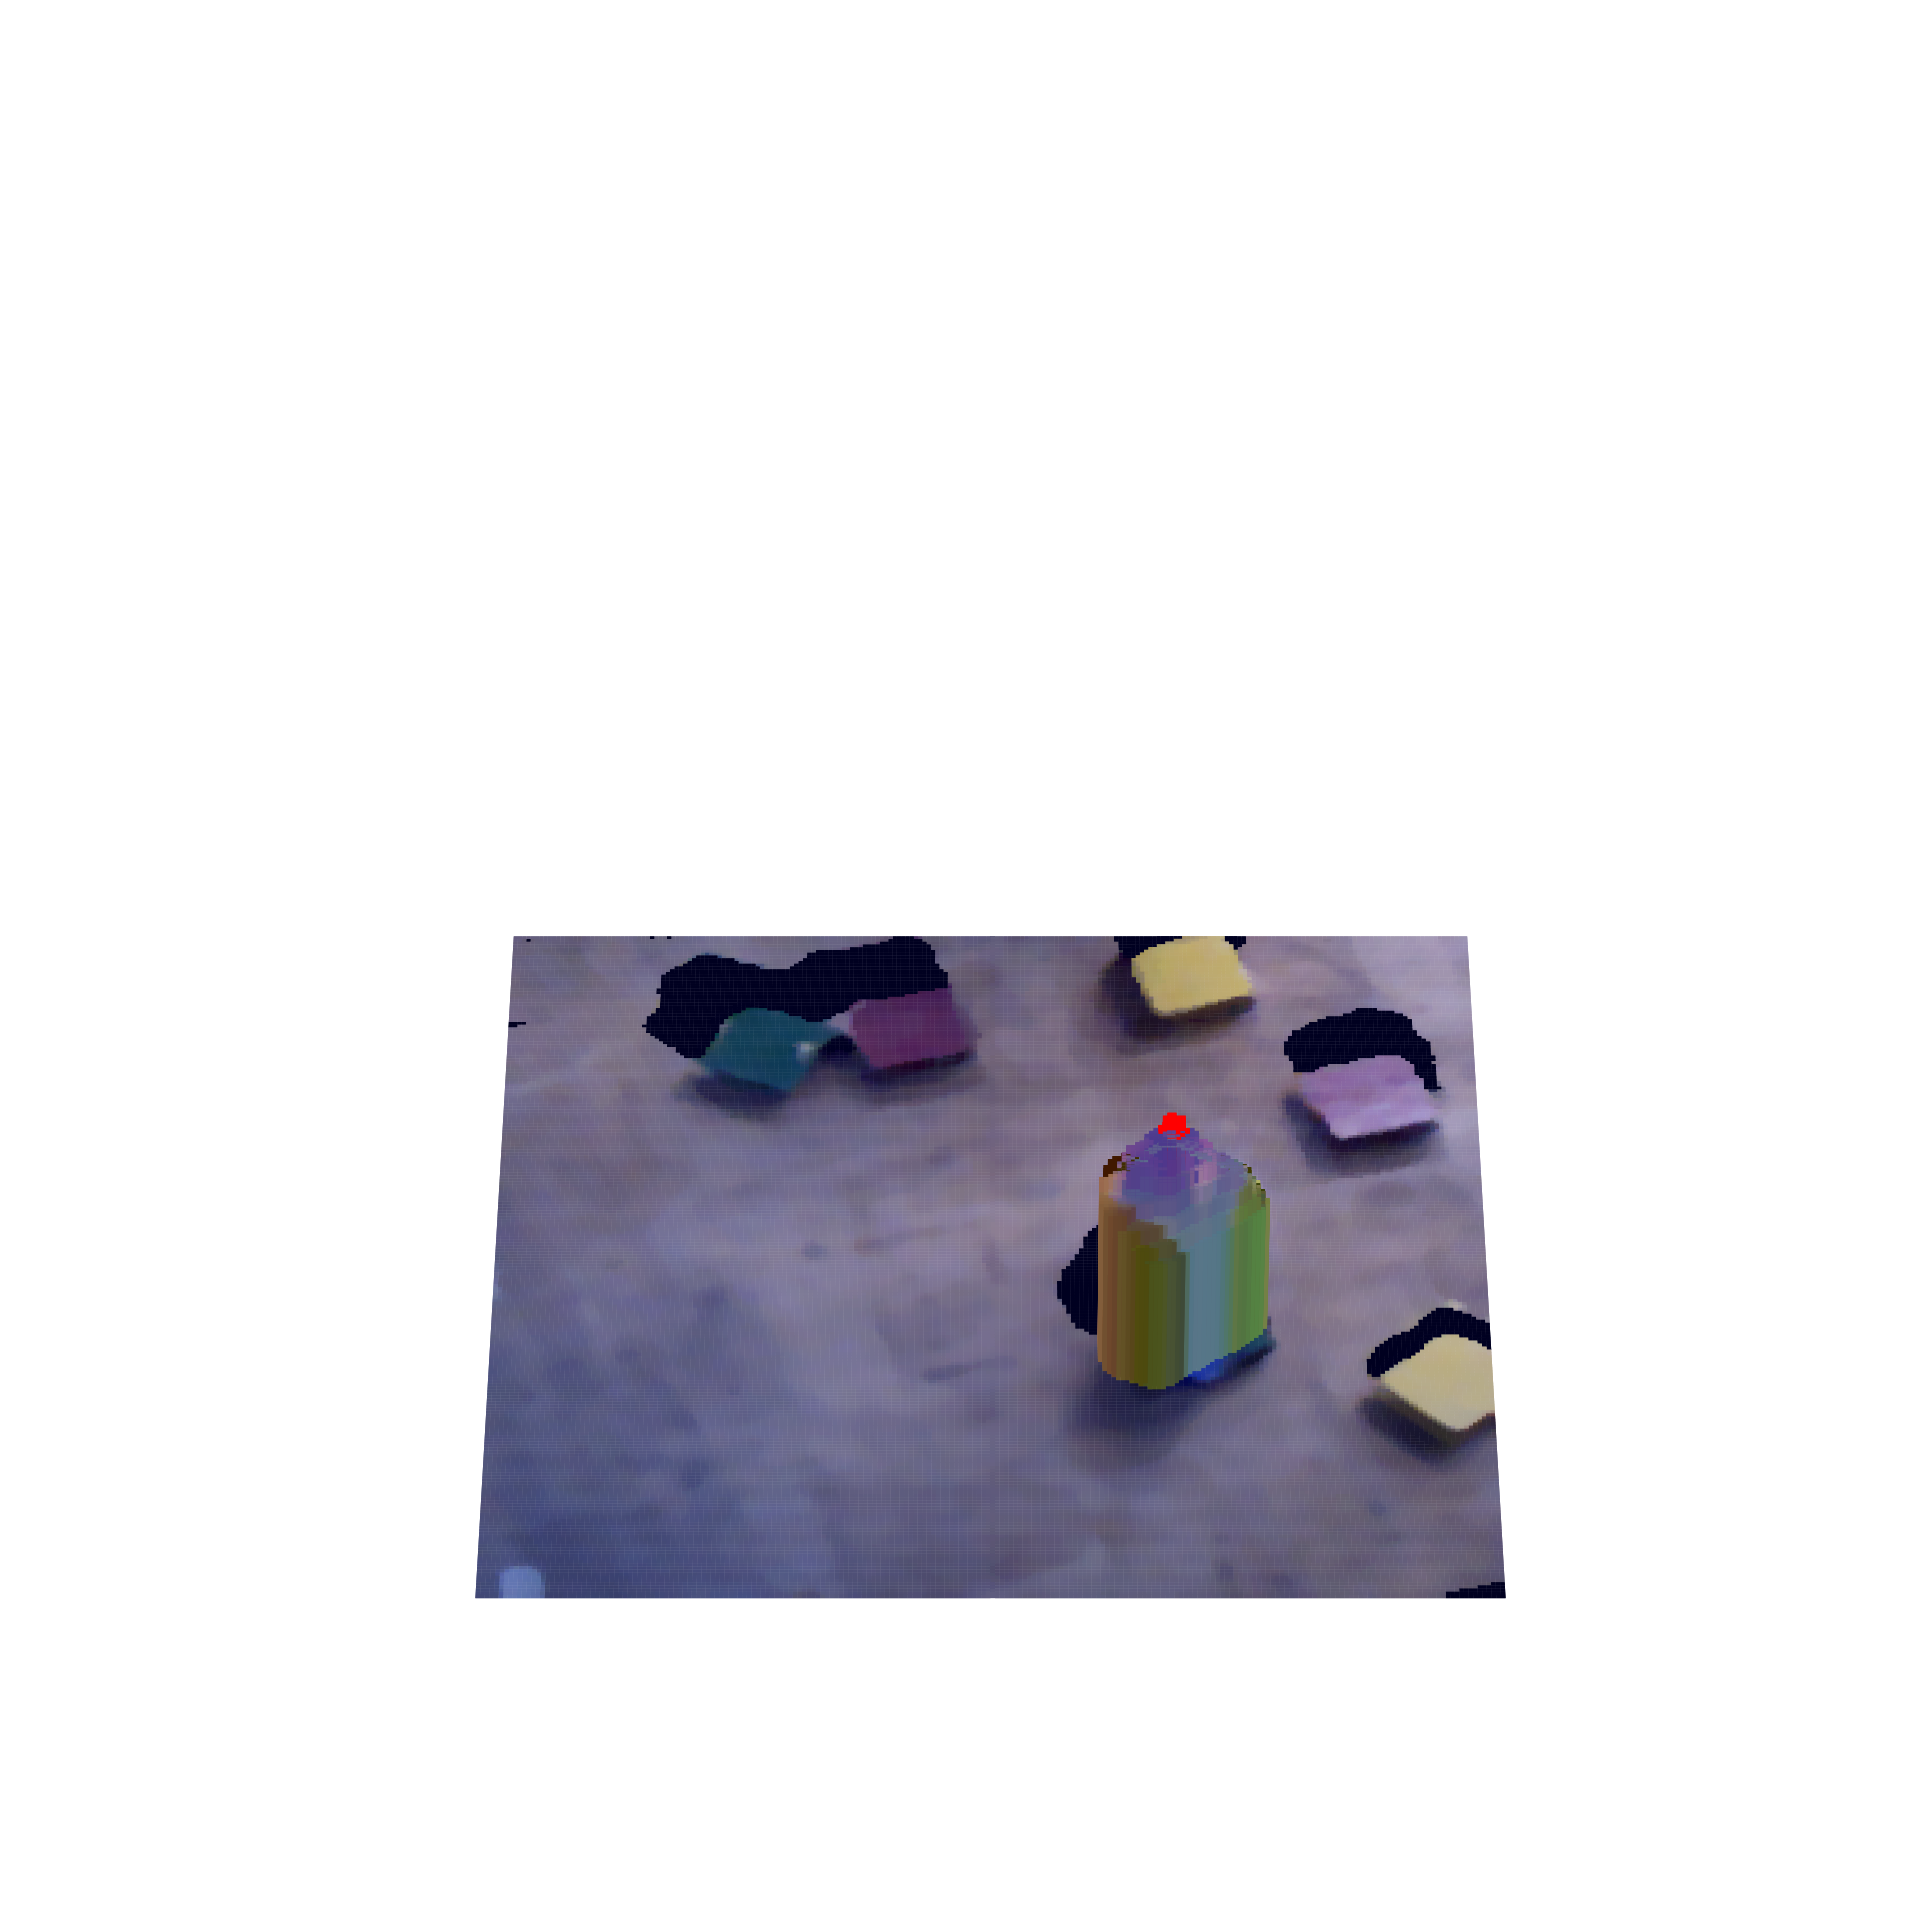

In [60]:
figure = plt.figure(figsize=(6, 4), dpi=600)
ax = figure.add_subplot(111, projection='3d')
# ax.view_init(elev=30., azim=90)
ax.view_init(elev=40., azim=90)

# ax.plot_surface(numpy.array(x), numpy.array(y), numpy.array(top), color=colors)
ax.bar3d(x, y, bottom, 1, 1, top, shade=False, color=colors)

ax.set_zlim(0, numpy.max(top)*3)
# ax.set_zlim(0, 500)

plt.axis('off')

plt.show()

In [22]:
figure.savefig("figures/test_cc_figure_v2.png", transparent=True)

94.86353836526439
0.0
True
(134, 71)


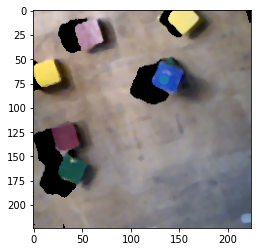

In [23]:
masked_test_color_heightmap = test_color_heightmap.copy()
masked_test_color_heightmap[test_mask,:] = 0
# best_test_action = numpy.unravel_index(numpy.argmin(rematch_distance), (224, 224))
best_test_action_index = numpy.argmax(top)
best_test_action = (y[best_test_action_index], x[best_test_action_index])
print(numpy.max(top))
print(inverse_heights[best_test_action])
print(test_mask[best_test_action])
print(best_test_action)

fig, ax = plt.subplots(1)

# ax.imshow(masked_test_color_heightmap)
# ax.imshow(inverse_heights, cmap='gray')
ax.imshow(test_color_heightmap)
# ax.imshow(test_mask)
ax.add_patch(Circle(best_test_action))



In [24]:
# TODO:
# Check rotation
# Tighter mask - N/A
# Subtract minimum nonzero value - done
# Try adding the match distance
# Save image files for figures - done
# Refactor